In [1]:
import numpy as np # linear algebra
run = 0
np.random.seed(run)
import os, glob, re
import time
import pyarrow as pa
import pyarrow.parquet as pq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.transform import rescale

from sklearn import metrics
from torch.utils.data import ConcatDataset, sampler, DataLoader #*
from eval_utils import logger, do_eval_binary, do_eval_binary_sky
from data_utils import ParquetDataset
from network_utils import *

import ROOT
from array import array

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, FixedLocator
%matplotlib inline
#plt.switch_backend('agg')
#plt.rcParams["figure.figsize"] = (5,5)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

Welcome to JupyROOT 6.24/06


In [2]:
# Specify which gpuid to use
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # :0 is always first *visible* device
#device = torch.device("cpu")

In [8]:
# H1
# premax
#expt_name = 'BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-premax16-fmaps4-8-16-blocks3_epochs50-ntrain72k-lr5Em04_run1' #epoch32,29
# deep
#expt_name = 'BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-premaxNone-fmaps4-6-8-12-16-blocks3-kernel3-down2_epochs50-ntrain72k-lr5Em04_run0' #epoch24,25
# stride
expt_name = 'BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-premaxNone-fmaps4-6-8-12-blocks3-kernel7-down3_epochs50-ntrain72k-lr5Em04_run0' #epoch18,27

# nobp
#expt_name = 'BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_nobp_resnet-scale5.0-shiftTrue-premaxNone-fmaps4-6-8-12-blocks3-kernel7-down3_epochs50-ntrain72k-lr5Em04_run0' #epoch21
chnl = 0

#L1
#expt_name = 'BBH-L1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-shiftFalse-premaxNone-fmaps4-6-8-12-blocks3-kernel7-down3_epochs50-ntrain72k-lr5Em04_run0' #13,18
#chnl = 1

#H1+L1
#expt_name = 'BBH-H1-L1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-shiftFalse-premaxNone-fmaps4-6-8-12-blocks3-kernel7-down3_epochs50-ntrain72k-lr5Em04_run0' #34,31
#expt_name = 'BBH-H1-L1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-shiftFalse-premaxNone-fmaps4-6-8-12-blocks1-kernel7-down3_epochs50-ntrain72k-lr5Em04_run0' #21
#chnl = None

epoch = 27 #18
scale = float(re.search('scale([0-9]+?.[0-9]+?)-', expt_name).group(1))
#nblocks = int(re.search('blocks([0-9]+?)_', expt_name).group(1))
nblocks = int(re.search('blocks([0-9]+?)-', expt_name).group(1))
#premax = int(re.search('premax([0-9]+?)-', expt_name).group(1))
premax = None

shift = True if 'nobp' in expt_name else False

#down = args.down
#fmaps = [4, 6, 8, 12, 16] # Resnet_deep
fmaps = [4, 6, 8, 12] # Resnet_stride
#fmaps = [4, 8, 16] # Resnet_premax
#fmaps = [8, 16, 32]
#fmaps = [24, 48, 96]
#premax = 64 # 2s->128
#premax = 16# 0.5s->128

print(scale, nblocks, premax)
#'''
model_file = glob.glob('MODELS/%s/model_epoch%d_auc*.pkl'%(expt_name, epoch))
print(model_file)
assert len(model_file) == 1
model_file = model_file[0]
print(">> Model file:", model_file)
'''
###################################################################
# Network architecture
#model = ResNet(in_channels=1, nblocks=nblocks, fmaps=fmaps, kernel=3, debug=debug)
if premax is None:
    if len(fmaps) == 5:
        logger(f, '>> Model: Resnet_deep')
        model = ResNet_deep(in_channels=1, nblocks=nblocks, fmaps=fmaps, kernel=kernel, debug=debug)
    else:
        logger(f, '>> Model: Resnet_stride')
        model = ResNet_stride(in_channels=1, nblocks=nblocks, fmaps=fmaps, down=down, kernel=kernel, debug=debug)
else:
    logger(f, '>> Model: Resnet_premax')
    model = ResNet_premax(in_channels=1, nblocks=nblocks, fmaps=fmaps, premax=premax, kernel=kernel, debug=debug)
'''
#model = ResNet_deep(in_channels=1, nblocks=nblocks, fmaps=fmaps, kernel=3)
model = ResNet_stride(in_channels=2 if chnl is None else 1, nblocks=nblocks, fmaps=fmaps, down=3, kernel=7)
#model = ResNet_premax(in_channels=1, nblocks=nblocks, fmaps=fmaps, premax=premax, kernel=3)
model.to(device)#.cuda()
model.load_state_dict(torch.load('%s'%model_file)['model'])

optimizer = optim.Adam(model.parameters(), lr=5.e-4) # not used, but needed by eval fn when making checkpoint

2.0 3 None
['MODELS/BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-premaxNone-fmaps4-6-8-12-blocks3-kernel7-down3_epochs50-ntrain72k-lr5Em04_run0/model_epoch27_auc0.9960.pkl']
>> Model file: MODELS/BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-premaxNone-fmaps4-6-8-12-blocks3-kernel7-down3_epochs50-ntrain72k-lr5Em04_run0/model_epoch27_auc0.9960.pkl


In [9]:
run = 0
np.random.seed(run)
torch.manual_seed(run)
###################################################################
# Load data
scenario = 'm20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s'
#scenario = 'm20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_nobp'
# Get parquet files
pqfiles = glob.glob('data/O1/parquet/%s/*_H1-L1_*.parquet'%scenario)
print('>> Input files: %s'%(' '.join(pqfiles)))
dset_train = ConcatDataset([ParquetDataset(pqf, scale, shift, chnl=chnl) for pqf in pqfiles])
print(len(dset_train))

idxs = np.random.permutation(len(dset_train))
print('>> Random(10): %s'%(' '.join([str(n) for n in np.random.permutation(10)])))
n_train = 72000
#n_train = 172000
if n_train != -1:
    assert n_train <= len(idxs)
    idxs_train = idxs[:n_train]
    idxs_val = idxs[n_train:]

# Test set _______________________________________________________________________
val_sampler = sampler.SubsetRandomSampler(idxs_val)
val_loader = DataLoader(dataset=dset_train, batch_size=32, num_workers=2, sampler=val_sampler)

>> Input files: data/O1/parquet/m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s/O1_H1-L1_local_idx004_bg.parquet data/O1/parquet/m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s/O1_H1-L1_local_idx004_sgbg.parquet
172960
>> Random(10): 2 1 8 9 3 4 5 0 7 6


In [10]:
aucs = []
tpr_fpr0s = []
losses = []
debug = False

losses, aucs, tpr_fpr0s, fprs, tprs, thrs, y_trues, y_preds, y_probs, dists, m1s, m2s, decs, ras, nnouts = \
do_eval_binary_sky(model, optimizer, device, val_loader, expt_name, epoch, losses, aucs, tpr_fpr0s, f=open('/dev/null', 'w'), debug=debug, write_model=False)

losses, aucs, tpr_fpr0s = np.array(losses), np.array(aucs), np.array(tpr_fpr0s)
print('>> Best Loss:%4.3E +/- %4.3E @ epoch:%d'%(np.min(losses), np.min(losses)/np.sqrt(len(idxs_val)), np.argwhere(losses==np.min(losses))[0][0]+1))
print('>> Best AUC:%4.3f +/- %4.3f @ epoch:%d'%(np.max(aucs), np.max(aucs)/np.sqrt(len(idxs_val)), np.argwhere(aucs==np.max(aucs))[0][0]+1))
print('>> Best TPR@FPR=0:%4.3f +/- %4.3f @ epoch:%d'%(np.max(tpr_fpr0s), np.max(tpr_fpr0s)/np.sqrt(len(idxs_val)*np.max(tpr_fpr0s)/2.), np.argwhere(tpr_fpr0s==np.max(tpr_fpr0s))[0][0]+1))

27: (0/3155) ...
27: (631/3155) ...
27: (1262/3155) ...
27: (1893/3155) ...
27: (2524/3155) ...
27: Val time:117.93s in 3155 steps for N:100960 samples
27: Val loss:0.037782, auc:0.995960, TPR@FPR=0:0.979262
>> Best Loss:3.778E-02 +/- 1.189E-04 @ epoch:1
>> Best AUC:0.996 +/- 0.003 @ epoch:1
>> Best TPR@FPR=0:0.979 +/- 0.004 @ epoch:1


In [11]:
metricsH = {}
metricsH['y_probs'] = np.array(y_probs)
metricsH['y_trues'] = np.array(y_trues)
metricsH['y_preds'] = np.array(y_preds)
metricsH['dists'] = np.array(dists)
metricsH['mtots'] = np.array(m1s)+np.array(m2s)
metricsH['decs'] = np.array(decs)
metricsH['ras'] = np.array(ras)
metricsH['nnouts'] = np.array(nnouts)

In [6]:
aucs = []
tpr_fpr0s = []
losses = []
debug = False

losses, aucs, tpr_fpr0s, fprs, tprs, thrs, y_trues, y_preds, y_probs, dists, m1s, m2s, decs, ras, nnouts = \
do_eval_binary_sky(model, optimizer, device, val_loader, expt_name, epoch, losses, aucs, tpr_fpr0s, f=open('/dev/null', 'w'), debug=debug, write_model=False)

losses, aucs, tpr_fpr0s = np.array(losses), np.array(aucs), np.array(tpr_fpr0s)
print('>> Best Loss:%4.3E +/- %4.3E @ epoch:%d'%(np.min(losses), np.min(losses)/np.sqrt(len(idxs_val)), np.argwhere(losses==np.min(losses))[0][0]+1))
print('>> Best AUC:%4.3f +/- %4.3f @ epoch:%d'%(np.max(aucs), np.max(aucs)/np.sqrt(len(idxs_val)), np.argwhere(aucs==np.max(aucs))[0][0]+1))
print('>> Best TPR@FPR=0:%4.3f +/- %4.3f @ epoch:%d'%(np.max(tpr_fpr0s), np.max(tpr_fpr0s)/np.sqrt(len(idxs_val)*np.max(tpr_fpr0s)/2.), np.argwhere(tpr_fpr0s==np.max(tpr_fpr0s))[0][0]+1))

18: (0/3155) ...
18: (631/3155) ...
18: (1262/3155) ...
18: (1893/3155) ...
18: (2524/3155) ...
18: Val time:300.41s in 3155 steps for N:100960 samples
18: Val loss:0.048041, auc:0.994775, TPR@FPR=0:0.966696
>> Best Loss:4.804E-02 +/- 1.512E-04 @ epoch:1
>> Best AUC:0.995 +/- 0.003 @ epoch:1
>> Best TPR@FPR=0:0.967 +/- 0.004 @ epoch:1


In [7]:
metricsL = {}
metricsL['y_probs'] = np.array(y_probs)
metricsL['y_trues'] = np.array(y_trues)
metricsL['y_preds'] = np.array(y_preds)
metricsL['dists'] = np.array(dists)
metricsL['mtots'] = np.array(m1s)+np.array(m2s)
metricsL['decs'] = np.array(decs)
metricsL['ras'] = np.array(ras)
metricsL['nnouts'] = np.array(nnouts)

In [164]:
aucs = []
tpr_fpr0s = []
losses = []
debug = False

losses, aucs, tpr_fpr0s, fprs, tprs, thrs, y_trues, y_preds, y_probs, dists, m1s, m2s, decs, ras, nnouts = \
do_eval_binary_sky(model, optimizer, device, val_loader, expt_name, epoch, losses, aucs, tpr_fpr0s, f=open('/dev/null', 'w'), debug=debug, write_model=False)

losses, aucs, tpr_fpr0s = np.array(losses), np.array(aucs), np.array(tpr_fpr0s)
print('>> Best Loss:%4.3E +/- %4.3E @ epoch:%d'%(np.min(losses), np.min(losses)/np.sqrt(len(idxs_val)), np.argwhere(losses==np.min(losses))[0][0]+1))
print('>> Best AUC:%4.3f +/- %4.3f @ epoch:%d'%(np.max(aucs), np.max(aucs)/np.sqrt(len(idxs_val)), np.argwhere(aucs==np.max(aucs))[0][0]+1))
print('>> Best TPR@FPR=0:%4.3f +/- %4.3f @ epoch:%d'%(np.max(tpr_fpr0s), np.max(tpr_fpr0s)/np.sqrt(len(idxs_val)*np.max(tpr_fpr0s)/2.), np.argwhere(tpr_fpr0s==np.max(tpr_fpr0s))[0][0]+1))

21: (0/3155) ...
21: (631/3155) ...
21: (1262/3155) ...
21: (1893/3155) ...
21: (2524/3155) ...
21: Val time:99.22s in 3155 steps for N:100960 samples
21: Val loss:0.017917, auc:0.998688, TPR@FPR=0:0.990635
>> Best Loss:1.792E-02 +/- 5.639E-05 @ epoch:1
>> Best AUC:0.999 +/- 0.003 @ epoch:1
>> Best TPR@FPR=0:0.991 +/- 0.004 @ epoch:1


In [227]:
metricsHL = {}
metricsHL['y_probs'] = np.array(y_probs)
metricsHL['y_trues'] = np.array(y_trues)
metricsHL['y_preds'] = np.array(y_preds)
metricsHL['dists'] = np.array(dists)
metricsHL['mtots'] = np.array(m1s)+np.array(m2s)
metricsHL['decs'] = np.array(decs)
metricsHL['ras'] = np.array(ras)
metricsHL['nnouts'] = np.array(nnouts)

In [12]:
print(metricsH['y_trues'][:10])
print(metricsL['y_trues'][:10])
#print(metricsHL['y_trues'][:10])

print(metricsH['y_probs'][:10])
print(metricsL['y_probs'][:10])
#print(metricsHL['y_probs'][:10])

assert np.array_equal(metricsH['y_trues'], metricsL['y_trues'])
assert np.array_equal(metricsH['y_trues'], metricsHL['y_trues'])
assert np.array_equal(metricsL['y_trues'], metricsHL['y_trues'])

[1. 1. 1. 0. 0. 0. 1. 1. 0. 0.]
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0.]
[1.         1.         1.         0.0047264  0.00163405 0.04605742
 1.         1.         0.00458471 0.00243088]
[1.         1.         1.         0.00433932 0.0071492  0.00895892
 1.         1.         0.00348627 0.00505392]


NameError: name 'metricsHL' is not defined

In [34]:
assert np.array_equal(metricsH['y_trues'], metricsL['y_trues'])
#fprs, tprs, thrs = metrics.roc_curve(y_trues, metricsH['y_probs']*metricsL['y_probs']) #y_preds)
#fprs, tprs, thrs = metrics.roc_curve(y_trues, 0.5*(metricsL['y_probs']+metricsL['y_probs'])) #y_preds)
fprs, tprs, thrs = metrics.roc_curve(y_trues, np.sqrt(metricsL['y_probs']*metricsL['y_probs'] + metricsH['y_probs']*metricsH['y_probs'])) #y_preds)
auc = metrics.auc(fprs, tprs)
idx_fpr0 = np.argwhere(fprs==0.)[-1][0]
tpr_fpr0 = tprs[idx_fpr0]
print('auc:%f, TPR@FPR=0:%f'%(auc, tpr_fpr0))

auc:0.998922, TPR@FPR=0:0.970534


In [14]:
def set_hist(h, xtitle, ytitle, htitle):
    #c.SetLeftMargin(0.16)
    #c.SetRightMargin(0.15)
    #c.SetBottomMargin(0.13)
    ROOT.gStyle.SetOptStat(0)

    h.GetXaxis().SetLabelSize(0.04)
    h.GetXaxis().SetLabelFont(42)
    h.GetXaxis().SetTitle(xtitle)
    h.GetXaxis().SetTitleOffset(0.09)
    h.GetXaxis().SetTitleSize(0.06)
    h.GetXaxis().SetTitleFont(42)

    h.GetYaxis().SetLabelSize(0.04)
    h.GetYaxis().SetLabelFont(42)
    h.GetYaxis().SetTitleOffset(1.2)
    h.GetYaxis().SetTitleSize(0.06)
    h.GetYaxis().SetTitleFont(42)
    h.GetYaxis().SetTitle(ytitle)

    h.SetTitleSize(0.04)
    h.SetTitleFont(62)
    h.SetTitle(htitle)
    h.SetTitleOffset(1.2)

    #return h, c
    return h

import LIGO_style
#tdrstyle.setTDRStyle()
ROOT.gStyle.SetPadTickX(1)
ROOT.gStyle.SetPadTickY(1)
#change the CMS_lumi variables (see CMS_lumi.py)
LIGO_style.writeExtraText = 1
LIGO_style.extraText = "Hanford"
LIGO_style.cmsTextOffset = 0.
#t_total = 8*4096 # s
t_total = int(0.5*len(idxs_val)/2)
t_total_h = t_total//(60*60) # h
t_total_m = (t_total%(60*60))//60 # m
t_total_s = t_total_m%(60) # s
t_total_str = '%sh%sm%ss'%(t_total_h, t_total_h, t_total_s)
LIGO_style.lumi_sqrtS = "%s (O1)"%t_total_str # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
#iPos = 11 # inside frame
iPos = 0 # above frame
if iPos==0: LIGO_style.relPosX = 0.16
iPeriod = 0
print(t_total_str)

h, c, hc = {}, {}, {}
line, legend = {}, {}
nbins = 20
wd, ht = int(480*1), int(420*1)

7h7m0s


bg: 7.83892666177693e-07 6.5707372070284515
sg: 0.00010412111009628345 74.26598358154297
sg2gl: 6.871189 +/- 1.931413
bg: 1.1811937202738604e-07 0.9900990099009901
sg: 1.56892909833391e-05 11.190628158855006
sg2gl: 6.871189 +/- 1.931413


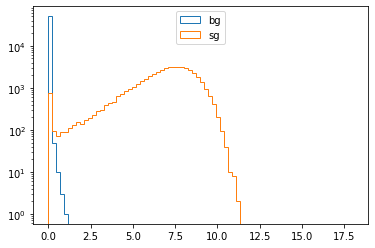

0.6238393478476986
[0 1 2 3 4 5 6]
[ 7 12 17 22 27 32 37 42 47 52 57 62 67 72 77]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80]
7h7m0s (O1)


Warning in <TROOT::Append>: Replacing existing TH1: nsgvqstat (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cnbgvqstat
Warning in <TROOT::Append>: Replacing existing TH1: nbgvqstat (Potential memory leak).


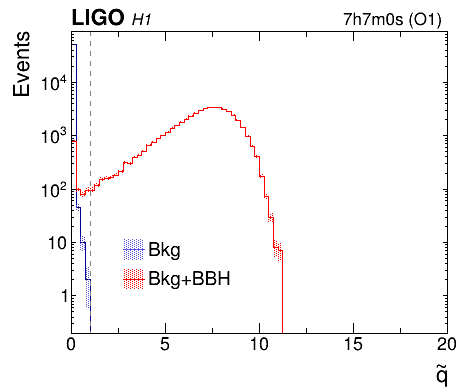

In [22]:
def plot_nnouts(nnouts, y_trues, nbins=76, qmax=18, plot_root=False, title='Hanford'):

    #qstat = nnouts
    qstat = np.log(1.+np.exp(nnouts))
    #qstat = 1.+np.exp(nnouts)
    #qstat = 1./(1 + np.exp(-nnouts))
    #xrange = [0., 10.]#qstat.max()]
    xrange = [qstat.min(), qstat.max() if qmax is None else qmax]

    bg_mask = (y_trues==0)
    sg_mask = (y_trues==1)

    qstat_bg = qstat[bg_mask]
    qstat_sg = qstat[sg_mask]
    
    print('bg:',qstat_bg.min(), qstat_bg.max())
    print('sg:',qstat_sg.min(), qstat_sg.max())
    print('sg2gl: %f +/- %f'%(np.mean(qstat_sg/qstat_bg.max()), np.std(qstat_sg/qstat_bg.max())))
    
    qstat_bg_max = qstat_bg.max()*1.01
    qstat_sg /= qstat_bg_max
    qstat_bg /= qstat_bg_max
    
    print('bg:',qstat_bg.min(), qstat_bg.max())
    print('sg:',qstat_sg.min(), qstat_sg.max())
    print('sg2gl: %f +/- %f'%(np.mean(qstat_sg/qstat_bg.max()), np.std(qstat_sg/qstat_bg.max())))
    
    plt.hist(qstat_bg, histtype='step', bins=nbins, label='bg', range=xrange)
    plt.hist(qstat_sg, histtype='step', bins=nbins, label='sg', range=xrange)
    #plt.xlim([0., 10.])
    #plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper center')
    plt.show()


    print(len(qstat_sg[qstat_sg>qstat_bg_max])/len(qstat_sg))
    
    if plot_root:
        # ROOT
        edges_ = {}
        #edges_[0] = np.arange(0,10,1)
        edges_[0] = np.arange(0,7,1)
        print(edges_[0])
        #edges_[1] = np.arange(10,80+10,10)
        edges_[1] = np.arange(7,77+5,5)
        print(edges_[1])
        edges = np.concatenate([edges_[e] for e in edges_])
        edges = np.arange(0,80+1,1)
        print(edges)

        nbins = len(edges)-1
        edges = array('d', edges)

        k = 'nsgvqstat'
        h[k] = ROOT.TH1F(k, k, 20*4, 0., 20.)
        #h[k] = ROOT.TH1F(k, k, nbins, edges)

        k = 'nbgvqstat'
        c[k] = ROOT.TCanvas('c'+k, 'c'+k, 480, 420)
        h[k] = ROOT.TH1F(k, k, 20*4, 0., 20.)
        #h[k] = ROOT.TH1F(k, k, nbins, edges)

        for q in qstat_bg:
            h['nbgvqstat'].Fill(q)

        for q in qstat_sg:
            h['nsgvqstat'].Fill(q)

        err_style = 'E2'
        fill_style = 3002
        LIGO_style.relPosX = 0.16

        k = 'nbgvqstat'
        c[k].cd()
        #h[k] = set_hist(h[k], 'FAR^{-1}', 'Events', '')
        h[k] = set_hist(h[k], '#tilde{q}', 'Events', '')
        ROOT.gPad.SetTopMargin(0.08)
        ROOT.gPad.SetBottomMargin(0.15)
        ROOT.gPad.SetLeftMargin(0.15)
        ROOT.gPad.SetRightMargin(0.06) # without colz
        ROOT.TGaxis.fgMaxDigits = 3
        ROOT.gStyle.SetOptStat(0)
        ROOT.gStyle.SetErrorX(0.5)
        #ROOT.gPad.SetLogx()
        ROOT.gPad.SetLogy()

        ymin, ymax = 2.e-1, 9.e4
        h[k].GetYaxis().SetRangeUser(ymin, ymax)
        h[k].GetYaxis().SetTitleOffset(1.1)
        h[k].GetYaxis().SetTitleSize(0.06)
        h[k].GetYaxis().SetLabelSize(0.05)
        h[k].GetYaxis().SetLabelFont(42)
        h[k].GetYaxis().SetTickLength(0.01)
        h[k].GetYaxis().SetTitleFont(42)
        h[k].GetYaxis().SetMaxDigits(3)
        h[k].GetYaxis().SetNdivisions(-4)

        h[k].GetXaxis().SetTitleOffset(1.1)
        h[k].GetXaxis().SetTitleSize(0.06)
        h[k].GetXaxis().SetLabelSize(0.05)
        h[k].GetXaxis().SetLabelFont(42)
        h[k].GetXaxis().SetTitleFont(42)
        #h[k].GetXaxis().SetNdivisions(-405)
        h[k].GetXaxis().SetNdivisions(409)
        #h[k].GetXaxis().ChangeLabel(-1,-1,-1,-1,-1,-1, "10^{#infty}")
        #h[k].GetXaxis().ChangeLabel(-1,-1,0,-1,-1,-1, "")

        # bg, line
        h[k].Draw('hist')
        # bg, band
        hc[k] = h[k].Clone()
        hc[k].SetName(k+'band')
        hc[k].SetMarkerStyle(1)
        hc[k].SetMarkerSize(0)
        hc[k].SetLineColor(9)
        hc[k].SetFillColor(9)
        hc[k].SetFillStyle(fill_style)
        hc[k].Draw("%s same"%err_style)

        k = 'nsgvqstat'
        # sg, line
        h[k].SetLineColor(2)
        h[k].Draw('hist same')
        # sg, band
        hc[k] = h[k].Clone()
        hc[k].SetName(k+'band')
        hc[k].SetMarkerStyle(1)
        hc[k].SetMarkerSize(0)
        hc[k].SetMarkerColor(2)
        hc[k].SetLineColor(2)
        hc[k].SetFillColor(2)
        hc[k].SetFillStyle(fill_style)
        hc[k].Draw("%s same"%err_style)

        k = 'nbgvqstat'
        legend[k] = ROOT.TLegend(0.25, 0.25, 0.25+0.25, 0.25+0.15) #(x1, y1, x2, y2)
        legend[k].AddEntry(hc['nbgvqstat'].GetName(), "Bkg",     "lf")
        legend[k].AddEntry(hc['nsgvqstat'].GetName(), "Bkg+BBH", "lf")
        legend[k].SetBorderSize(0)
        legend[k].SetTextFont(42)
        legend[k].Draw("same")

        kl1 = k+'l1'
        #line[kl1] = ROOT.TLine(np.ceil(qstat_bg_max), 0., np.ceil(qstat_bg_max), ymax) # x0,y0, x1,y1
        line[kl1] = ROOT.TLine(1., 0., 1., ymax) # x0,y0, x1,y1
        line[kl1].SetLineColor(14)
        line[kl1].SetLineStyle(7)
        line[kl1].Draw("same")

        #kl2 = k+'l2'
        #line[kl2] = ROOT.TLine(fprinv_max, 0., fprinv_max, ymax) # x0,y0, x1,y1
        #line[kl2].SetLineColor(14)
        #line[kl2].SetLineStyle(7)
        #line[kl2].Draw("same")

        c[k].RedrawAxis()
        c[k].Draw()
        
        LIGO_style.extraText = title

        LIGO_style.LIGO_style(c[k], iPeriod, iPos)

plot_root=True
#plot_root=False
plot_nnouts(metricsH['nnouts'], metricsH['y_trues'], plot_root=plot_root, title='H1')
#plot_nnouts(metricsL['nnouts'], metricsL['y_trues'], plot_root=plot_root, title='L1')
#plot_nnouts(metricsHL['nnouts'], metricsHL['y_trues'], plot_root=plot_root, title='H1+L1')

bg: 0.0023820308857206416 6.570738828361073
sg: 0.005217541695623966 81.12945715313391
sg2gl: 7.892692 +/- 2.025578
bg: 0.00035893169445814794 0.99009900990099
sg: 0.0007861951299383692 12.224834573307534
sg2gl: 7.892692 +/- 2.025578


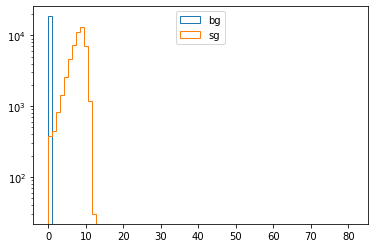

0.7690824137588229
[0 1 2 3 4 5 6]
[ 7 12 17 22 27 32 37 42 47 52 57 62 67 72 77]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80]
7h7m0s (O1)


Warning in <TROOT::Append>: Replacing existing TH1: nsgvqstat (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cnbgvqstat
Warning in <TROOT::Append>: Replacing existing TH1: nbgvqstat (Potential memory leak).


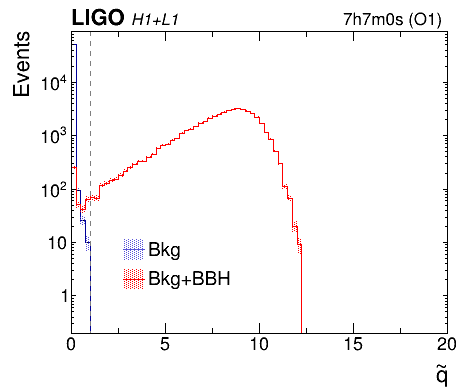

In [33]:
def plot_nnouts_joint(nnouts1, nnouts2, y_trues, nbins=76, qmax=18, plot_root=False, title='H1+L1'):

    qstat1 = np.log(1.+np.exp(nnouts1))
    qstat2 = np.log(1.+np.exp(nnouts2))
    #qstat = qstat1*qstat2
    qstat = np.sqrt(qstat1*qstat1 + qstat2*qstat2)
    #qstat = (qstat1+qstat2)/2.
    #qstat -= qstat.min()
    xrange = [qstat.min(), qstat.max()]# if qmax is None else qmax]

    bg_mask = (y_trues==0)
    sg_mask = (y_trues==1)

    qstat_bg = qstat[bg_mask]
    qstat_sg = qstat[sg_mask]
    
    print('bg:',qstat_bg.min(), qstat_bg.max())
    print('sg:',qstat_sg.min(), qstat_sg.max())
    print('sg2gl: %f +/- %f'%(np.mean(qstat_sg/qstat_bg.max()), np.std(qstat_sg/qstat_bg.max())))
    
    qstat_bg_max = qstat_bg.max()*1.01
    qstat_sg /= qstat_bg_max
    qstat_bg /= qstat_bg_max
    
    print('bg:',qstat_bg.min(), qstat_bg.max())
    print('sg:',qstat_sg.min(), qstat_sg.max())
    print('sg2gl: %f +/- %f'%(np.mean(qstat_sg/qstat_bg.max()), np.std(qstat_sg/qstat_bg.max())))
    
    plt.hist(qstat_bg, histtype='step', bins=nbins, label='bg', range=xrange)
    plt.hist(qstat_sg, histtype='step', bins=nbins, label='sg', range=xrange)
    #plt.xlim([0., 10.])
    #plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper center')
    plt.show()

    print(len(qstat_sg[qstat_sg>qstat_bg_max])/len(qstat_sg))
    
    if plot_root:
        # ROOT
        edges_ = {}
        #edges_[0] = np.arange(0,10,1)
        edges_[0] = np.arange(0,7,1)
        print(edges_[0])
        #edges_[1] = np.arange(10,80+10,10)
        edges_[1] = np.arange(7,77+5,5)
        print(edges_[1])
        edges = np.concatenate([edges_[e] for e in edges_])
        edges = np.arange(0,80+1,1)
        print(edges)

        nbins = len(edges)-1
        edges = array('d', edges)

        k = 'nsgvqstat'
        h[k] = ROOT.TH1F(k, k, 20*4, 0., 20.)
        #h[k] = ROOT.TH1F(k, k, nbins, edges)

        k = 'nbgvqstat'
        c[k] = ROOT.TCanvas('c'+k, 'c'+k, 480, 420)
        h[k] = ROOT.TH1F(k, k, 20*4, 0., 20.)
        #h[k] = ROOT.TH1F(k, k, nbins, edges)

        for q in qstat_bg:
            h['nbgvqstat'].Fill(q)

        for q in qstat_sg:
            h['nsgvqstat'].Fill(q)

        err_style = 'E2'
        fill_style = 3002
        LIGO_style.relPosX = 0.16

        k = 'nbgvqstat'
        c[k].cd()
        #h[k] = set_hist(h[k], 'FAR^{-1}', 'Events', '')
        h[k] = set_hist(h[k], '#tilde{q}', 'Events', '')
        ROOT.gPad.SetTopMargin(0.08)
        ROOT.gPad.SetBottomMargin(0.15)
        ROOT.gPad.SetLeftMargin(0.15)
        ROOT.gPad.SetRightMargin(0.06) # without colz
        ROOT.TGaxis.fgMaxDigits = 3
        ROOT.gStyle.SetOptStat(0)
        ROOT.gStyle.SetErrorX(0.5)
        #ROOT.gPad.SetLogx()
        ROOT.gPad.SetLogy()

        ymin, ymax = 2.e-1, 9.e4
        h[k].GetYaxis().SetRangeUser(ymin, ymax)
        h[k].GetYaxis().SetTitleOffset(1.1)
        h[k].GetYaxis().SetTitleSize(0.06)
        h[k].GetYaxis().SetLabelSize(0.05)
        h[k].GetYaxis().SetLabelFont(42)
        h[k].GetYaxis().SetTickLength(0.01)
        h[k].GetYaxis().SetTitleFont(42)
        h[k].GetYaxis().SetMaxDigits(3)
        h[k].GetYaxis().SetNdivisions(-4)

        h[k].GetXaxis().SetTitleOffset(1.1)
        h[k].GetXaxis().SetTitleSize(0.06)
        h[k].GetXaxis().SetLabelSize(0.05)
        h[k].GetXaxis().SetLabelFont(42)
        h[k].GetXaxis().SetTitleFont(42)
        #h[k].GetXaxis().SetNdivisions(-405)
        h[k].GetXaxis().SetNdivisions(409)
        #h[k].GetXaxis().ChangeLabel(-1,-1,-1,-1,-1,-1, "10^{#infty}")
        #h[k].GetXaxis().ChangeLabel(-1,-1,0,-1,-1,-1, "")

        # bg, line
        h[k].Draw('hist')
        # bg, band
        hc[k] = h[k].Clone()
        hc[k].SetName(k+'band')
        hc[k].SetMarkerStyle(1)
        hc[k].SetMarkerSize(0)
        hc[k].SetLineColor(9)
        hc[k].SetFillColor(9)
        hc[k].SetFillStyle(fill_style)
        hc[k].Draw("%s same"%err_style)

        k = 'nsgvqstat'
        # sg, line
        h[k].SetLineColor(2)
        h[k].Draw('hist same')
        # sg, band
        hc[k] = h[k].Clone()
        hc[k].SetName(k+'band')
        hc[k].SetMarkerStyle(1)
        hc[k].SetMarkerSize(0)
        hc[k].SetMarkerColor(2)
        hc[k].SetLineColor(2)
        hc[k].SetFillColor(2)
        hc[k].SetFillStyle(fill_style)
        hc[k].Draw("%s same"%err_style)

        k = 'nbgvqstat'
        legend[k] = ROOT.TLegend(0.25, 0.25, 0.25+0.25, 0.25+0.15) #(x1, y1, x2, y2)
        legend[k].AddEntry(hc['nbgvqstat'].GetName(), "Bkg",     "lf")
        legend[k].AddEntry(hc['nsgvqstat'].GetName(), "Bkg+BBH", "lf")
        legend[k].SetBorderSize(0)
        legend[k].SetTextFont(42)
        legend[k].Draw("same")

        kl1 = k+'l1'
        #line[kl1] = ROOT.TLine(np.ceil(qstat_bg_max), 0., np.ceil(qstat_bg_max), ymax) # x0,y0, x1,y1
        line[kl1] = ROOT.TLine(1., 0., 1., ymax) # x0,y0, x1,y1
        line[kl1].SetLineColor(14)
        line[kl1].SetLineStyle(7)
        line[kl1].Draw("same")

        #kl2 = k+'l2'
        #line[kl2] = ROOT.TLine(fprinv_max, 0., fprinv_max, ymax) # x0,y0, x1,y1
        #line[kl2].SetLineColor(14)
        #line[kl2].SetLineStyle(7)
        #line[kl2].Draw("same")

        c[k].RedrawAxis()
        c[k].Draw()
        
        LIGO_style.extraText = title

        LIGO_style.LIGO_style(c[k], iPeriod, iPos)

plot_root=True
#plot_root=False
plot_nnouts_joint(metricsH['nnouts'], metricsL['nnouts'], metricsH['y_trues'], plot_root=plot_root, title='H1+L1')

diff, bg: -0.03174224903437162 0.9992744738933141
diff, sg: -0.1785249001235698 9.278672142944592
eff, bg: dq < 0: 0.319 +/- 0.003
eff, bg: dq > 0: 0.681 +/- 0.004
eff, sg: dq < 0: 0.014 +/- 0.001
eff, sg: dq > 0: 0.986 +/- 0.004
0.31889864798184153 0.6811013520181585
0.014156476786956954 0.985843523213043


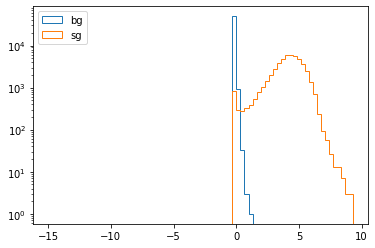

[0 1 2 3 4 5 6]
[ 7 12 17 22 27 32 37 42 47 52 57 62 67 72 77]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80]
7h7m0s (O1)


Warning in <TROOT::Append>: Replacing existing TH1: diffsg (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cdiffbg
Warning in <TROOT::Append>: Replacing existing TH1: diffbg (Potential memory leak).


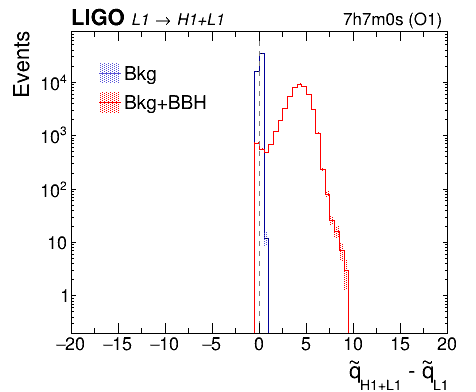

In [38]:
def plot_diffs_joint(nnouts1, nnouts2, y_trues, nbins=76, plot_root=False, title='H1'):

    '''
    qstat1 = np.log(1.+np.exp(nnouts1))
    qstat2 = np.log(1.+np.exp(nnouts2))
    diff = qstat2-qstat1

    bg_mask = (y_trues==0)
    sg_mask = (y_trues==1)

    diff_bg = diff[bg_mask]
    diff_sg = diff[sg_mask]
    '''
    qstat1 = np.log(1.+np.exp(nnouts1))
    qstat2 = np.log(1.+np.exp(nnouts2))
    #qstat = qstat1*qstat2
    #qstat = np.sqrt(qstat1*qstat2)
    qstat = np.sqrt(qstat1*qstat1 + qstat2*qstat2)
    #qstat = (qstat1+qstat2)/2.
    #qstat -= qstat.min()
    #xrange = [qstat.min(), qstat.max()]# if qmax is None else qmax]

    bg_mask = (y_trues==0)
    sg_mask = (y_trues==1)

    qstat1_bg = qstat1[bg_mask]
    qstat1_sg = qstat1[sg_mask]
    
    qstat_bg = qstat[bg_mask]
    qstat_sg = qstat[sg_mask]
    
    qstat_bg_max = qstat_bg.max()
    qstat_sg /= qstat_bg_max
    qstat_bg /= qstat_bg_max
    
    qstat1_bg_max = qstat1_bg.max()
    qstat1_sg /= qstat1_bg_max
    qstat1_bg /= qstat1_bg_max
    
    diff_bg = qstat_bg-qstat1_bg
    diff_sg = qstat_sg-qstat1_sg

    print('diff, bg:',diff_bg.min(), diff_bg.max())
    print('diff, sg:',diff_sg.min(), diff_sg.max())
    #xrange = [diff.min(), diff.max()] #qstat.max()]
    #xrange = [-15., 15.] #qstat.max()]
    xrange = [-15., diff_sg.max()] #qstat.max()]
    print('eff, bg: dq < 0: %.3f +/- %.3f'%(1.*len(diff_bg[diff_bg<=0.])/len(diff_bg), (1.*len(diff_bg[diff_bg<=0.])/len(diff_bg))/np.sqrt(1.*len(diff_bg[diff_bg<=0.]))))
    print('eff, bg: dq > 0: %.3f +/- %.3f'%(1.*len(diff_bg[diff_bg>0.])/len(diff_bg), (1.*len(diff_bg[diff_bg>0.])/len(diff_bg))/np.sqrt(1.*len(diff_bg[diff_bg>0.]))))
    print('eff, sg: dq < 0: %.3f +/- %.3f'%(1.*len(diff_sg[diff_sg<=0.])/len(diff_sg), (1.*len(diff_sg[diff_sg<=0.])/len(diff_sg))/np.sqrt(1.*len(diff_sg[diff_sg<=0.]))))
    print('eff, sg: dq > 0: %.3f +/- %.3f'%(1.*len(diff_sg[diff_sg>0.])/len(diff_sg), (1.*len(diff_sg[diff_sg>0.])/len(diff_sg))/np.sqrt(1.*len(diff_sg[diff_sg>0.]))))
    print(1.*len(diff_bg[diff_bg<=0.])/len(diff_bg), 1.*len(diff_bg[diff_bg>0])/len(diff_bg))
    print(1.*len(diff_sg[diff_sg<=0.])/len(diff_sg), 1.*len(diff_sg[diff_sg>0])/len(diff_sg))
    plt.hist(diff_bg, histtype='step', bins=nbins, label='bg', range=xrange)
    plt.hist(diff_sg, histtype='step', bins=nbins, label='sg', range=xrange)
    #plt.xlim([0., 10.])
    #plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper left')
    plt.show()

    if plot_root:
        # ROOT
        edges_ = {}
        #edges_[0] = np.arange(0,10,1)
        edges_[0] = np.arange(0,7,1)
        print(edges_[0])
        #edges_[1] = np.arange(10,80+10,10)
        edges_[1] = np.arange(7,77+5,5)
        print(edges_[1])
        edges = np.concatenate([edges_[e] for e in edges_])
        edges = np.arange(0,80+1,1)
        print(edges)

        nbins = len(edges)-1
        edges = array('d', edges)

        k = 'diffsg'
        h[k] = ROOT.TH1F(k, k, 80, -20., 20.)
        #h[k] = ROOT.TH1F(k, k, nbins, edges)

        k = 'diffbg'
        c[k] = ROOT.TCanvas('c'+k, 'c'+k, 480, 420)
        h[k] = ROOT.TH1F(k, k, 80, -20., 20.)
        #h[k] = ROOT.TH1F(k, k, nbins, edges)

        for d in diff_bg:
            h['diffbg'].Fill(d)

        for d in diff_sg:
            h['diffsg'].Fill(d)

        err_style = 'E2'
        fill_style = 3002
        LIGO_style.relPosX = 0.16

        k = 'diffbg'
        c[k].cd()
        #h[k] = set_hist(h[k], 'FAR^{-1}', 'Events', '')
        h[k] = set_hist(h[k], '#tilde{q}_{H1+L1} - #tilde{q}_{%s}'%title, 'Events', '')
        ROOT.gPad.SetTopMargin(0.08)
        ROOT.gPad.SetBottomMargin(0.15)
        ROOT.gPad.SetLeftMargin(0.15)
        ROOT.gPad.SetRightMargin(0.06) # without colz
        ROOT.TGaxis.fgMaxDigits = 3
        ROOT.gStyle.SetOptStat(0)
        ROOT.gStyle.SetErrorX(0.5)
        #ROOT.gPad.SetLogx()
        ROOT.gPad.SetLogy()

        ymin, ymax = 2.e-1, 9.e4
        h[k].GetYaxis().SetRangeUser(ymin, ymax)
        h[k].GetYaxis().SetTitleOffset(1.1)
        h[k].GetYaxis().SetTitleSize(0.06)
        h[k].GetYaxis().SetLabelSize(0.05)
        h[k].GetYaxis().SetLabelFont(42)
        h[k].GetYaxis().SetTickLength(0.01)
        h[k].GetYaxis().SetTitleFont(42)
        h[k].GetYaxis().SetMaxDigits(3)
        h[k].GetYaxis().SetNdivisions(-4)

        h[k].GetXaxis().SetTitleOffset(1.1)
        h[k].GetXaxis().SetTitleSize(0.06)
        h[k].GetXaxis().SetLabelSize(0.05)
        h[k].GetXaxis().SetLabelFont(42)
        h[k].GetXaxis().SetTitleFont(42)
        #h[k].GetXaxis().SetNdivisions(-405)
        h[k].GetXaxis().SetNdivisions(409)
        #h[k].GetXaxis().ChangeLabel(-1,-1,-1,-1,-1,-1, "10^{#infty}")
        #h[k].GetXaxis().ChangeLabel(-1,-1,0,-1,-1,-1, "")

        # bg, line
        h[k].Draw('hist')
        # bg, band
        hc[k] = h[k].Clone()
        hc[k].SetName(k+'band')
        hc[k].SetMarkerStyle(1)
        hc[k].SetMarkerSize(0)
        hc[k].SetLineColor(9)
        hc[k].SetFillColor(9)
        hc[k].SetFillStyle(fill_style)
        hc[k].Draw("%s same"%err_style)

        k = 'diffsg'
        # sg, line
        h[k].SetLineColor(2)
        h[k].Draw('hist same')
        # sg, band
        hc[k] = h[k].Clone()
        hc[k].SetName(k+'band')
        hc[k].SetMarkerStyle(1)
        hc[k].SetMarkerSize(0)
        hc[k].SetMarkerColor(2)
        hc[k].SetLineColor(2)
        hc[k].SetFillColor(2)
        hc[k].SetFillStyle(fill_style)
        hc[k].Draw("%s same"%err_style)

        k = 'diffbg'
        legend[k] = ROOT.TLegend(0.2, 0.7, 0.2+0.25, 0.7+0.15) #(x1, y1, x2, y2)
        legend[k].AddEntry(hc['diffbg'].GetName(), "Bkg",     "lf")
        legend[k].AddEntry(hc['diffsg'].GetName(), "Bkg+BBH", "lf")
        legend[k].SetBorderSize(0)
        legend[k].SetTextFont(42)
        legend[k].Draw("same")

        kl1 = k+'l1'
        #line[kl1] = ROOT.TLine(np.ceil(qstat_bg_max), 0., np.ceil(qstat_bg_max), ymax) # x0,y0, x1,y1
        line[kl1] = ROOT.TLine(0., 0., 0., ymax) # x0,y0, x1,y1
        line[kl1].SetLineColor(14)
        line[kl1].SetLineStyle(7)
        line[kl1].Draw("same")

        #kl2 = k+'l2'
        #line[kl2] = ROOT.TLine(fprinv_max, 0., fprinv_max, ymax) # x0,y0, x1,y1
        #line[kl2].SetLineColor(14)
        #line[kl2].SetLineStyle(7)
        #line[kl2].Draw("same")

        c[k].RedrawAxis()
        c[k].Draw()
        
        LIGO_style.extraText = '%s #rightarrow H1+L1'%title

        LIGO_style.LIGO_style(c[k], iPeriod, iPos)

plot_root = True
#plot_diffs(metricsH['nnouts'], metricsHL['nnouts'], metricsHL['y_trues'], plot_root=plot_root, title='H1')
plot_diffs_joint(metricsL['nnouts'], metricsH['nnouts'], metricsH['y_trues'], plot_root=plot_root, title='L1')

diff, bg: -0.9888055738755143 0.808126556615984
diff, sg: -2.9885644250120507 13.039393231036454
eff, bg: dq < 0: 0.881 +/- 0.004
eff, bg: dq > 0: 0.119 +/- 0.002
eff, sg: dq < 0: 0.006 +/- 0.000
eff, sg: dq > 0: 0.994 +/- 0.004
0.8808645021217804 0.11913549787821968
0.006402226861517049 0.993597773138483


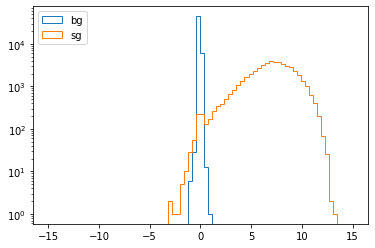

[0 1 2 3 4 5 6]
[ 7 12 17 22 27 32 37 42 47 52 57 62 67 72 77]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80]
7h7m0s (O1)


Warning in <TROOT::Append>: Replacing existing TH1: diffsg (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cdiffbg
Warning in <TROOT::Append>: Replacing existing TH1: diffbg (Potential memory leak).


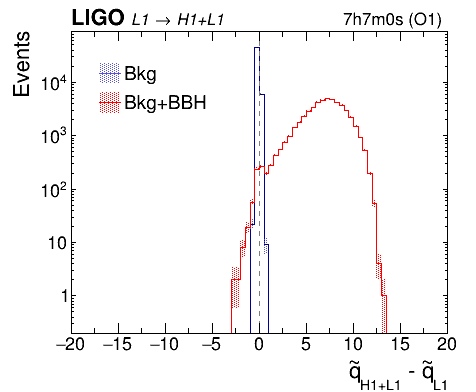

In [220]:
def plot_diffs(nnouts1, nnouts2, y_trues, nbins=76, plot_root=False, title='H1'):

    '''
    qstat1 = np.log(1.+np.exp(nnouts1))
    qstat2 = np.log(1.+np.exp(nnouts2))
    diff = qstat2-qstat1

    bg_mask = (y_trues==0)
    sg_mask = (y_trues==1)

    diff_bg = diff[bg_mask]
    diff_sg = diff[sg_mask]
    '''
    qstat1 = np.log(1.+np.exp(nnouts1))
    qstat2 = np.log(1.+np.exp(nnouts2))

    bg_mask = (y_trues==0)
    sg_mask = (y_trues==1)

    qstat1_bg = qstat1[bg_mask]
    qstat1_sg = qstat1[sg_mask]
    
    qstat2_bg = qstat2[bg_mask]
    qstat2_sg = qstat2[sg_mask]
    
    qstat2_bg_max = qstat2_bg.max()
    qstat2_sg /= qstat2_bg_max
    qstat2_bg /= qstat2_bg_max
    
    qstat1_bg_max = qstat1_bg.max()
    qstat1_sg /= qstat1_bg_max
    qstat1_bg /= qstat1_bg_max
    
    diff_bg = qstat2_bg-qstat1_bg
    diff_sg = qstat2_sg-qstat1_sg

    print('diff, bg:',diff_bg.min(), diff_bg.max())
    print('diff, sg:',diff_sg.min(), diff_sg.max())
    #xrange = [diff.min(), diff.max()] #qstat.max()]
    xrange = [-15., 15.] #qstat.max()]
    print('eff, bg: dq < 0: %.3f +/- %.3f'%(1.*len(diff_bg[diff_bg<=0.])/len(diff_bg), (1.*len(diff_bg[diff_bg<=0.])/len(diff_bg))/np.sqrt(1.*len(diff_bg[diff_bg<=0.]))))
    print('eff, bg: dq > 0: %.3f +/- %.3f'%(1.*len(diff_bg[diff_bg>0.])/len(diff_bg), (1.*len(diff_bg[diff_bg>0.])/len(diff_bg))/np.sqrt(1.*len(diff_bg[diff_bg>0.]))))
    print('eff, sg: dq < 0: %.3f +/- %.3f'%(1.*len(diff_sg[diff_sg<=0.])/len(diff_sg), (1.*len(diff_sg[diff_sg<=0.])/len(diff_sg))/np.sqrt(1.*len(diff_sg[diff_sg<=0.]))))
    print('eff, sg: dq > 0: %.3f +/- %.3f'%(1.*len(diff_sg[diff_sg>0.])/len(diff_sg), (1.*len(diff_sg[diff_sg>0.])/len(diff_sg))/np.sqrt(1.*len(diff_sg[diff_sg>0.]))))
    print(1.*len(diff_bg[diff_bg<=0.])/len(diff_bg), 1.*len(diff_bg[diff_bg>0])/len(diff_bg))
    print(1.*len(diff_sg[diff_sg<=0.])/len(diff_sg), 1.*len(diff_sg[diff_sg>0])/len(diff_sg))
    plt.hist(diff_bg, histtype='step', bins=nbins, label='bg', range=xrange)
    plt.hist(diff_sg, histtype='step', bins=nbins, label='sg', range=xrange)
    #plt.xlim([0., 10.])
    #plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper left')
    plt.show()

    if plot_root:
        # ROOT
        edges_ = {}
        #edges_[0] = np.arange(0,10,1)
        edges_[0] = np.arange(0,7,1)
        print(edges_[0])
        #edges_[1] = np.arange(10,80+10,10)
        edges_[1] = np.arange(7,77+5,5)
        print(edges_[1])
        edges = np.concatenate([edges_[e] for e in edges_])
        edges = np.arange(0,80+1,1)
        print(edges)

        nbins = len(edges)-1
        edges = array('d', edges)

        k = 'diffsg'
        h[k] = ROOT.TH1F(k, k, 80, -20., 20.)
        #h[k] = ROOT.TH1F(k, k, nbins, edges)

        k = 'diffbg'
        c[k] = ROOT.TCanvas('c'+k, 'c'+k, 480, 420)
        h[k] = ROOT.TH1F(k, k, 80, -20., 20.)
        #h[k] = ROOT.TH1F(k, k, nbins, edges)

        for d in diff_bg:
            h['diffbg'].Fill(d)

        for d in diff_sg:
            h['diffsg'].Fill(d)

        err_style = 'E2'
        fill_style = 3002
        LIGO_style.relPosX = 0.16

        k = 'diffbg'
        c[k].cd()
        #h[k] = set_hist(h[k], 'FAR^{-1}', 'Events', '')
        h[k] = set_hist(h[k], '#tilde{q}_{H1+L1} - #tilde{q}_{%s}'%title, 'Events', '')
        ROOT.gPad.SetTopMargin(0.08)
        ROOT.gPad.SetBottomMargin(0.15)
        ROOT.gPad.SetLeftMargin(0.15)
        ROOT.gPad.SetRightMargin(0.06) # without colz
        ROOT.TGaxis.fgMaxDigits = 3
        ROOT.gStyle.SetOptStat(0)
        ROOT.gStyle.SetErrorX(0.5)
        #ROOT.gPad.SetLogx()
        ROOT.gPad.SetLogy()

        ymin, ymax = 2.e-1, 9.e4
        h[k].GetYaxis().SetRangeUser(ymin, ymax)
        h[k].GetYaxis().SetTitleOffset(1.1)
        h[k].GetYaxis().SetTitleSize(0.06)
        h[k].GetYaxis().SetLabelSize(0.05)
        h[k].GetYaxis().SetLabelFont(42)
        h[k].GetYaxis().SetTickLength(0.01)
        h[k].GetYaxis().SetTitleFont(42)
        h[k].GetYaxis().SetMaxDigits(3)
        h[k].GetYaxis().SetNdivisions(-4)

        h[k].GetXaxis().SetTitleOffset(1.1)
        h[k].GetXaxis().SetTitleSize(0.06)
        h[k].GetXaxis().SetLabelSize(0.05)
        h[k].GetXaxis().SetLabelFont(42)
        h[k].GetXaxis().SetTitleFont(42)
        #h[k].GetXaxis().SetNdivisions(-405)
        h[k].GetXaxis().SetNdivisions(409)
        #h[k].GetXaxis().ChangeLabel(-1,-1,-1,-1,-1,-1, "10^{#infty}")
        #h[k].GetXaxis().ChangeLabel(-1,-1,0,-1,-1,-1, "")

        # bg, line
        h[k].Draw('hist')
        # bg, band
        hc[k] = h[k].Clone()
        hc[k].SetName(k+'band')
        hc[k].SetMarkerStyle(1)
        hc[k].SetMarkerSize(0)
        hc[k].SetLineColor(9)
        hc[k].SetFillColor(9)
        hc[k].SetFillStyle(fill_style)
        hc[k].Draw("%s same"%err_style)

        k = 'diffsg'
        # sg, line
        h[k].SetLineColor(2)
        h[k].Draw('hist same')
        # sg, band
        hc[k] = h[k].Clone()
        hc[k].SetName(k+'band')
        hc[k].SetMarkerStyle(1)
        hc[k].SetMarkerSize(0)
        hc[k].SetMarkerColor(2)
        hc[k].SetLineColor(2)
        hc[k].SetFillColor(2)
        hc[k].SetFillStyle(fill_style)
        hc[k].Draw("%s same"%err_style)

        k = 'diffbg'
        legend[k] = ROOT.TLegend(0.2, 0.7, 0.2+0.25, 0.7+0.15) #(x1, y1, x2, y2)
        legend[k].AddEntry(hc['diffbg'].GetName(), "Bkg",     "lf")
        legend[k].AddEntry(hc['diffsg'].GetName(), "Bkg+BBH", "lf")
        legend[k].SetBorderSize(0)
        legend[k].SetTextFont(42)
        legend[k].Draw("same")

        kl1 = k+'l1'
        #line[kl1] = ROOT.TLine(np.ceil(qstat_bg_max), 0., np.ceil(qstat_bg_max), ymax) # x0,y0, x1,y1
        line[kl1] = ROOT.TLine(0., 0., 0., ymax) # x0,y0, x1,y1
        line[kl1].SetLineColor(14)
        line[kl1].SetLineStyle(7)
        line[kl1].Draw("same")

        #kl2 = k+'l2'
        #line[kl2] = ROOT.TLine(fprinv_max, 0., fprinv_max, ymax) # x0,y0, x1,y1
        #line[kl2].SetLineColor(14)
        #line[kl2].SetLineStyle(7)
        #line[kl2].Draw("same")

        c[k].RedrawAxis()
        c[k].Draw()
        
        LIGO_style.extraText = '%s #rightarrow H1+L1'%title

        LIGO_style.LIGO_style(c[k], iPeriod, iPos)

plot_root = True
#plot_diffs(metricsH['nnouts'], metricsHL['nnouts'], metricsHL['y_trues'], plot_root=plot_root, title='H1')
plot_diffs(metricsL['nnouts'], metricsHL['nnouts'], metricsHL['y_trues'], plot_root=plot_root, title='L1')

qstat, bg: min:0.002382, max:6.570739
qstat, sg: min:0.005218, max:81.129457
dists: min:100.012596, max:499.996826
mtots: min:-198.000000, max:99.908421
0.8723404255319149 1.0
7h7m0s (O1)


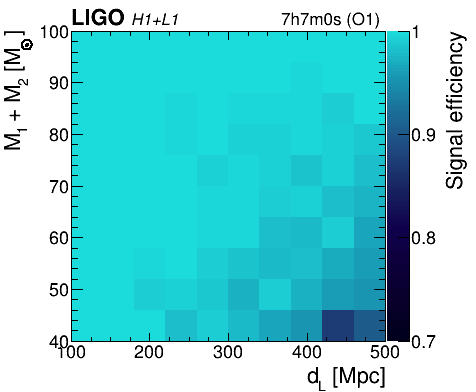

In [40]:
def plot_phase_joint(nnouts1, nnouts2, y_trues, dists, mtots, nbins=76, plot_root=False, title='H1'):

    qstat1 = np.log(1.+np.exp(nnouts1))
    qstat2 = np.log(1.+np.exp(nnouts2))
    qstat = np.sqrt(qstat1*qstat1 + qstat2*qstat2)

    bg_mask = (y_trues==0)
    sg_mask = (y_trues==1)

    qstat_bg = qstat[bg_mask]
    qstat_sg = qstat[sg_mask]
    print('qstat, bg: min:%f, max:%f'%(qstat_bg.min(), qstat_bg.max()))
    print('qstat, sg: min:%f, max:%f'%(qstat_sg.min(), qstat_sg.max()))
    
    qstat_bg_max = qstat_bg.max()
    
    dists_sg = dists[sg_mask]
    mtots_sg = mtots[sg_mask]
    print('dists: min:%f, max:%f'%(dists_sg.min(), dists_sg.max()))
    print('mtots: min:%f, max:%f'%(mtots.min(), mtots.max()))

    # ROOT
    k = 'sgeffqstat'

    c[k] = ROOT.TCanvas('c'+k, 'c'+k, wd, ht)
    h[k] = ROOT.TProfile2D('h'+k, 'h'+k, 10, 100, 500, 10, 40, 100)

    #y_probs_sg = y_probs[sg_mask]
    for i in range(len(mtots_sg)):
        # top k
        #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if qstat_sg[i] >= 50. else 0.)
        #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if (qstat_sg[i] < 50. and qstat_sg[i] > qstat_bg_max) else 0.)
        # high-purity regime
        h[k].Fill(dists_sg[i], mtots_sg[i], 1. if qstat_sg[i] > qstat_bg_max else 0.)
        # glitch regime
        #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if (qstat_sg[i] < qstat_bg_max and qstat_sg[i] >= 1.) else 0.)
        # nois regime
        #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if qstat_sg[i] < 1. else 0.)

    print(h[k].GetMinimum(), h[k].GetMaximum())

    err_style = 'E2'
    fill_style = 3002
    LIGO_style.relPosX = 0.19

    k = 'sgeffqstat'

    c[k].cd()
    h[k] = set_hist(h[k], 'd_{L} [Mpc]', 'M_{1} + M_{2} [M_{#odot} ]', '')
    ROOT.gPad.SetTopMargin(0.08)
    ROOT.gPad.SetBottomMargin(0.13)
    ROOT.gPad.SetLeftMargin(0.15)
    ROOT.gPad.SetRightMargin(0.19) # with colz
    #ROOT.gPad.SetRightMargin(0.1) # without colz
    ROOT.gStyle.SetPalette(51)#53:kDarkBodyRadiator, 51:kDeepSea, 52:Gray
    ROOT.TGaxis.fgMaxDigits = 3
    ROOT.gStyle.SetOptStat(0)
    ROOT.gPad.SetLogz(0) #0:set False, 1:set True

    ymin, ymax = 40., 100.
    h[k].GetYaxis().SetRangeUser(ymin, ymax)
    h[k].GetYaxis().SetTitleOffset(1.2)
    h[k].GetYaxis().SetTitleSize(0.06)
    h[k].GetYaxis().SetLabelSize(0.05)
    h[k].GetYaxis().SetLabelFont(42)
    h[k].GetYaxis().SetTitleFont(42)
    #h[k].GetYaxis().ChangeLabel(1,-1,0,-1,-1,-1, "")

    h[k].GetXaxis().SetTitleOffset(1.0)
    h[k].GetXaxis().SetTitleSize(0.06)
    h[k].GetXaxis().SetLabelSize(0.05)
    h[k].GetXaxis().SetLabelFont(42)
    h[k].GetXaxis().SetTitleFont(42)
    h[k].GetXaxis().SetNdivisions(-404)

    h[k].GetZaxis().SetTitle('Signal efficiency')
    h[k].GetZaxis().SetTitleOffset(1.)
    h[k].GetZaxis().SetTitleSize(0.06)
    h[k].GetZaxis().SetLabelSize(0.05)
    h[k].GetZaxis().SetTitleFont(42)
    h[k].GetZaxis().SetLabelFont(42)
    h[k].GetZaxis().SetNdivisions(-3)

    h[k].SetMaximum(1.)
    h[k].SetMinimum(0.7)
    h[k].SetContour(100)
    h[k].Draw('COLZ')

    #h[k].SetContour(5)
    #h[k].Draw('CONT3')

    c[k].Draw()

    LIGO_style.extraText = '%s'%title

    LIGO_style.LIGO_style(c[k], iPeriod, iPos)

plot_root = True
plot_phase_joint(metricsH['nnouts'], metricsL['nnouts'], metricsL['y_trues'], metricsL['dists'], metricsL['mtots'], plot_root=plot_root, title='H1+L1')

qstat, bg: min:0.001335, max:6.362167
qstat, sg: min:0.001889, max:40.083237
dists: min:100.012596, max:499.996826
mtots: min:-198.000000, max:99.908421
0.7232142857142857 1.0
7h7m0s (O1)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: csgeffqstat
Warning in <TROOT::Append>: Replacing existing TH1: hsgeffqstat (Potential memory leak).


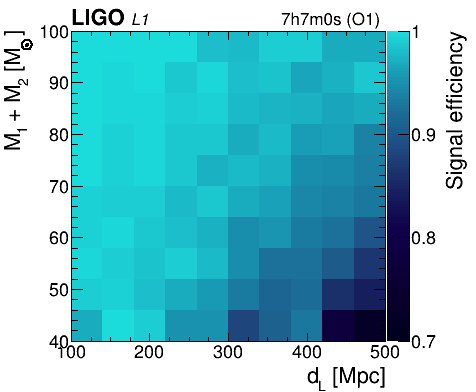

In [236]:
def plot_phase(nnouts, y_trues, dists, mtots, nbins=76, plot_root=False, title='H1'):

    qstat = np.log(1.+np.exp(nnouts))

    bg_mask = (y_trues==0)
    sg_mask = (y_trues==1)

    qstat_bg = qstat[bg_mask]
    qstat_sg = qstat[sg_mask]
    print('qstat, bg: min:%f, max:%f'%(qstat_bg.min(), qstat_bg.max()))
    print('qstat, sg: min:%f, max:%f'%(qstat_sg.min(), qstat_sg.max()))
    
    qstat_bg_max = qstat_bg.max()
    
    dists_sg = dists[sg_mask]
    mtots_sg = mtots[sg_mask]
    print('dists: min:%f, max:%f'%(dists_sg.min(), dists_sg.max()))
    print('mtots: min:%f, max:%f'%(mtots.min(), mtots.max()))

    # ROOT
    k = 'sgeffqstat'

    c[k] = ROOT.TCanvas('c'+k, 'c'+k, wd, ht)
    h[k] = ROOT.TProfile2D('h'+k, 'h'+k, 10, 100, 500, 10, 40, 100)

    #y_probs_sg = y_probs[sg_mask]
    for i in range(len(mtots_sg)):
        # top k
        #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if qstat_sg[i] >= 50. else 0.)
        #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if (qstat_sg[i] < 50. and qstat_sg[i] > qstat_bg_max) else 0.)
        # high-purity regime
        h[k].Fill(dists_sg[i], mtots_sg[i], 1. if qstat_sg[i] > qstat_bg_max else 0.)
        # glitch regime
        #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if (qstat_sg[i] < qstat_bg_max and qstat_sg[i] >= 1.) else 0.)
        # nois regime
        #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if qstat_sg[i] < 1. else 0.)

    print(h[k].GetMinimum(), h[k].GetMaximum())

    err_style = 'E2'
    fill_style = 3002
    LIGO_style.relPosX = 0.19

    k = 'sgeffqstat'

    c[k].cd()
    h[k] = set_hist(h[k], 'd_{L} [Mpc]', 'M_{1} + M_{2} [M_{#odot} ]', '')
    ROOT.gPad.SetTopMargin(0.08)
    ROOT.gPad.SetBottomMargin(0.13)
    ROOT.gPad.SetLeftMargin(0.15)
    ROOT.gPad.SetRightMargin(0.19) # with colz
    #ROOT.gPad.SetRightMargin(0.1) # without colz
    ROOT.gStyle.SetPalette(51)#53:kDarkBodyRadiator, 51:kDeepSea, 52:Gray
    ROOT.TGaxis.fgMaxDigits = 3
    ROOT.gStyle.SetOptStat(0)
    ROOT.gPad.SetLogz(0) #0:set False, 1:set True

    ymin, ymax = 40., 100.
    h[k].GetYaxis().SetRangeUser(ymin, ymax)
    h[k].GetYaxis().SetTitleOffset(1.2)
    h[k].GetYaxis().SetTitleSize(0.06)
    h[k].GetYaxis().SetLabelSize(0.05)
    h[k].GetYaxis().SetLabelFont(42)
    h[k].GetYaxis().SetTitleFont(42)
    #h[k].GetYaxis().ChangeLabel(1,-1,0,-1,-1,-1, "")

    h[k].GetXaxis().SetTitleOffset(1.0)
    h[k].GetXaxis().SetTitleSize(0.06)
    h[k].GetXaxis().SetLabelSize(0.05)
    h[k].GetXaxis().SetLabelFont(42)
    h[k].GetXaxis().SetTitleFont(42)
    h[k].GetXaxis().SetNdivisions(-404)

    h[k].GetZaxis().SetTitle('Signal efficiency')
    h[k].GetZaxis().SetTitleOffset(1.)
    h[k].GetZaxis().SetTitleSize(0.06)
    h[k].GetZaxis().SetLabelSize(0.05)
    h[k].GetZaxis().SetTitleFont(42)
    h[k].GetZaxis().SetLabelFont(42)
    h[k].GetZaxis().SetNdivisions(-3)

    h[k].SetMaximum(1.)
    h[k].SetMinimum(0.7)
    h[k].SetContour(100)
    h[k].Draw('COLZ')

    #h[k].SetContour(5)
    #h[k].Draw('CONT3')

    c[k].Draw()

    LIGO_style.extraText = '%s'%title

    LIGO_style.LIGO_style(c[k], iPeriod, iPos)

plot_root = True
plot_phase(metricsL['nnouts'], metricsL['y_trues'], metricsL['dists'], metricsL['mtots'], plot_root=plot_root, title='L1')
#plot_phase(metricsHL['nnouts'], metricsHL['y_trues'], metricsHL['dists'], metricsHL['mtots'], plot_root=plot_root, title='H1+L1')

qstat, bg: min:0.002382, max:6.570739
qstat, sg: min:0.005218, max:81.129457
decs: min:-1.570777, max:1.570746
ras: min:0.000161, max:6.283116
0.8771186440677966 1.0
7h7m0s (O1)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cdecraFPRinvmax
Warning in <TROOT::Append>: Replacing existing TH1: hdecraFPRinvmax (Potential memory leak).


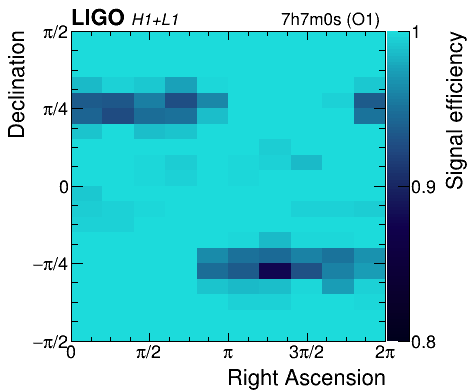

In [43]:
def plot_sky_joint(nnouts1, nnouts2, y_trues, decs, ras, nbins=76, plot_root=False, title='H1'):

    qstat1 = np.log(1.+np.exp(nnouts1))
    qstat2 = np.log(1.+np.exp(nnouts2))
    qstat = np.sqrt(qstat1*qstat1 + qstat2*qstat2)

    bg_mask = (y_trues==0)
    sg_mask = (y_trues==1)

    qstat_bg = qstat[bg_mask]
    qstat_sg = qstat[sg_mask]
    print('qstat, bg: min:%f, max:%f'%(qstat_bg.min(), qstat_bg.max()))
    print('qstat, sg: min:%f, max:%f'%(qstat_sg.min(), qstat_sg.max()))
    
    qstat_bg_max = qstat_bg.max()
    
    decs_sg = decs[sg_mask]
    ras_sg = ras[sg_mask]
    print('decs: min:%f, max:%f'%(decs_sg.min(), decs_sg.max()))
    print('ras: min:%f, max:%f'%(ras_sg.min(), ras_sg.max()))

    # ROOT
    k = 'decraFPRinvmax'
    c[k] = ROOT.TCanvas('c'+k, 'c'+k, wd, ht)
    h[k] = ROOT.TProfile2D('h'+k, 'h'+k, 10, 0, 2*np.pi, 20, -np.pi/2., np.pi/2)

    for i in range(len(decs_sg)):
        
        dec_ = decs_sg[i] if decs_sg[i] < np.pi/2. else decs_sg[i] - np.pi
        # top k
        #h[k].Fill(ras_sg[i], dec_, 1. if qstat_sg[i] >= 50. else 0.)
        #h[k].Fill(ras_sg[i], dec_, 1. if (qstat_sg[i] < 50. and qstat_sg[i] > qstat_bg_max) else 0.)
        # high-purity regime
        h[k].Fill(ras_sg[i], dec_, 1. if qstat_sg[i] > qstat_bg_max else 0.)
        # glitch regime
        #h[k].Fill(ras_sg[i], dec_, 1. if (qstat_sg[i] < qstat_bg_max and qstat_sg[i] >= 1.) else 0.)
        # nois regime
        #h[k].Fill(ras_sg[i], dec_, 1. if qstat_sg[i] < 1. else 0.)

    print(h[k].GetMinimum(), h[k].GetMaximum())

    err_style = 'E2'
    fill_style = 3002
    LIGO_style.relPosX = 0.19
    
    k = 'decraFPRinvmax'

    c[k].cd()
    h[k] = set_hist(h[k], 'Right Ascension', 'Declination', '')
    ROOT.gPad.SetTopMargin(0.08)
    ROOT.gPad.SetBottomMargin(0.13)
    ROOT.gPad.SetLeftMargin(0.15)
    ROOT.gPad.SetRightMargin(0.19) # with colz
    #ROOT.gPad.SetRightMargin(0.1) # without colz
    ROOT.gStyle.SetPalette(51)#53:kDarkBodyRadiator, 51:kDeepSea, 52:Gray
    ROOT.TGaxis.fgMaxDigits = 3
    ROOT.gStyle.SetOptStat(0)
    ROOT.gPad.SetLogz(0) #0:set False, 1:set True

    ymin, ymax = 40., 100.
    #h[k].GetYaxis().SetRangeUser(ymin, ymax)
    h[k].GetYaxis().SetTitleOffset(1.2)
    h[k].GetYaxis().SetTitleSize(0.06)
    h[k].GetYaxis().SetLabelSize(0.05)
    h[k].GetYaxis().SetLabelFont(42)
    h[k].GetYaxis().SetTitleFont(42)
    h[k].GetYaxis().SetNdivisions(-404)
    h[k].GetYaxis().ChangeLabel(1,-1,-1,-1,-1,-1, "-#pi/2")
    h[k].GetYaxis().ChangeLabel(2,-1,-1,-1,-1,-1, "-#pi/4")
    h[k].GetYaxis().ChangeLabel(3,-1,-1,-1,-1,-1, "0")
    h[k].GetYaxis().ChangeLabel(4,-1,-1,-1,-1,-1, "#pi/4")
    h[k].GetYaxis().ChangeLabel(5,-1,-1,-1,-1,-1, "#pi/2")

    h[k].GetXaxis().SetTitleOffset(1.0)
    h[k].GetXaxis().SetTitleSize(0.06)
    h[k].GetXaxis().SetLabelSize(0.05)
    h[k].GetXaxis().SetLabelFont(42)
    h[k].GetXaxis().SetTitleFont(42)
    h[k].GetXaxis().SetNdivisions(-404)
    h[k].GetXaxis().ChangeLabel(1,-1,-1,-1,-1,-1, "0")
    h[k].GetXaxis().ChangeLabel(2,-1,-1,-1,-1,-1, "#pi/2")
    h[k].GetXaxis().ChangeLabel(3,-1,-1,-1,-1,-1, "#pi")
    h[k].GetXaxis().ChangeLabel(-2,-1,-1,-1,-1,-1, "3#pi/2")
    h[k].GetXaxis().ChangeLabel(-1,-1,-1,-1,-1,-1, "2#pi")

    h[k].GetZaxis().SetTitle('Signal efficiency')
    h[k].GetZaxis().SetTitleOffset(1.)
    h[k].GetZaxis().SetTitleSize(0.06)
    h[k].GetZaxis().SetLabelSize(0.05)
    h[k].GetZaxis().SetTitleFont(42)
    h[k].GetZaxis().SetLabelFont(42)
    h[k].GetZaxis().SetNdivisions(-2)

    h[k].SetMaximum(1.)
    h[k].SetMinimum(0.8)
    h[k].SetContour(100)
    h[k].Draw('COLZ')

    #h[k].SetContour(6)
    #h[k].Draw('CONT3')

    c[k].Draw()
    c[k].Update()

    LIGO_style.extraText = '%s'%title

    LIGO_style.LIGO_style(c[k], iPeriod, iPos)

plot_root = True
plot_sky_joint(metricsH['nnouts'], metricsL['nnouts'], metricsL['y_trues'], metricsL['decs'], metricsL['ras'], plot_root=plot_root, title='H1+L1')

qstat, bg: min:0.001335, max:6.362167
qstat, sg: min:0.001889, max:40.083237
decs: min:-1.570777, max:1.570746
ras: min:0.000161, max:6.283116
0.8008474576271186 1.0
7h7m0s (O1)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cdecraFPRinvmax
Warning in <TROOT::Append>: Replacing existing TH1: hdecraFPRinvmax (Potential memory leak).


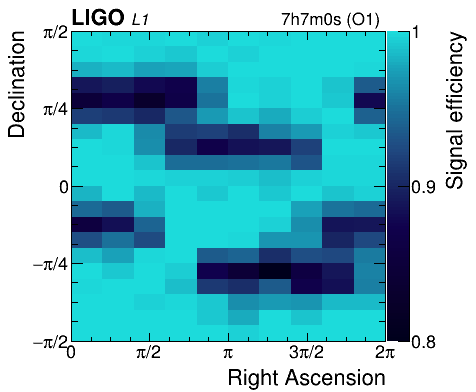

In [237]:
def plot_sky(nnouts, y_trues, decs, ras, nbins=76, plot_root=False, title='H1'):

    qstat = np.log(1.+np.exp(nnouts))

    bg_mask = (y_trues==0)
    sg_mask = (y_trues==1)

    qstat_bg = qstat[bg_mask]
    qstat_sg = qstat[sg_mask]
    print('qstat, bg: min:%f, max:%f'%(qstat_bg.min(), qstat_bg.max()))
    print('qstat, sg: min:%f, max:%f'%(qstat_sg.min(), qstat_sg.max()))
    
    qstat_bg_max = qstat_bg.max()
    
    decs_sg = decs[sg_mask]
    ras_sg = ras[sg_mask]
    print('decs: min:%f, max:%f'%(decs_sg.min(), decs_sg.max()))
    print('ras: min:%f, max:%f'%(ras_sg.min(), ras_sg.max()))

    # ROOT
    k = 'decraFPRinvmax'
    c[k] = ROOT.TCanvas('c'+k, 'c'+k, wd, ht)
    h[k] = ROOT.TProfile2D('h'+k, 'h'+k, 10, 0, 2*np.pi, 20, -np.pi/2., np.pi/2)

    for i in range(len(decs_sg)):
        
        dec_ = decs_sg[i] if decs_sg[i] < np.pi/2. else decs_sg[i] - np.pi
        # top k
        #h[k].Fill(ras_sg[i], dec_, 1. if qstat_sg[i] >= 50. else 0.)
        #h[k].Fill(ras_sg[i], dec_, 1. if (qstat_sg[i] < 50. and qstat_sg[i] > qstat_bg_max) else 0.)
        # high-purity regime
        h[k].Fill(ras_sg[i], dec_, 1. if qstat_sg[i] > qstat_bg_max else 0.)
        # glitch regime
        #h[k].Fill(ras_sg[i], dec_, 1. if (qstat_sg[i] < qstat_bg_max and qstat_sg[i] >= 1.) else 0.)
        # nois regime
        #h[k].Fill(ras_sg[i], dec_, 1. if qstat_sg[i] < 1. else 0.)

    print(h[k].GetMinimum(), h[k].GetMaximum())

    err_style = 'E2'
    fill_style = 3002
    LIGO_style.relPosX = 0.19
    
    k = 'decraFPRinvmax'

    c[k].cd()
    h[k] = set_hist(h[k], 'Right Ascension', 'Declination', '')
    ROOT.gPad.SetTopMargin(0.08)
    ROOT.gPad.SetBottomMargin(0.13)
    ROOT.gPad.SetLeftMargin(0.15)
    ROOT.gPad.SetRightMargin(0.19) # with colz
    #ROOT.gPad.SetRightMargin(0.1) # without colz
    ROOT.gStyle.SetPalette(51)#53:kDarkBodyRadiator, 51:kDeepSea, 52:Gray
    ROOT.TGaxis.fgMaxDigits = 3
    ROOT.gStyle.SetOptStat(0)
    ROOT.gPad.SetLogz(0) #0:set False, 1:set True

    ymin, ymax = 40., 100.
    #h[k].GetYaxis().SetRangeUser(ymin, ymax)
    h[k].GetYaxis().SetTitleOffset(1.2)
    h[k].GetYaxis().SetTitleSize(0.06)
    h[k].GetYaxis().SetLabelSize(0.05)
    h[k].GetYaxis().SetLabelFont(42)
    h[k].GetYaxis().SetTitleFont(42)
    h[k].GetYaxis().SetNdivisions(-404)
    h[k].GetYaxis().ChangeLabel(1,-1,-1,-1,-1,-1, "-#pi/2")
    h[k].GetYaxis().ChangeLabel(2,-1,-1,-1,-1,-1, "-#pi/4")
    h[k].GetYaxis().ChangeLabel(3,-1,-1,-1,-1,-1, "0")
    h[k].GetYaxis().ChangeLabel(4,-1,-1,-1,-1,-1, "#pi/4")
    h[k].GetYaxis().ChangeLabel(5,-1,-1,-1,-1,-1, "#pi/2")

    h[k].GetXaxis().SetTitleOffset(1.0)
    h[k].GetXaxis().SetTitleSize(0.06)
    h[k].GetXaxis().SetLabelSize(0.05)
    h[k].GetXaxis().SetLabelFont(42)
    h[k].GetXaxis().SetTitleFont(42)
    h[k].GetXaxis().SetNdivisions(-404)
    h[k].GetXaxis().ChangeLabel(1,-1,-1,-1,-1,-1, "0")
    h[k].GetXaxis().ChangeLabel(2,-1,-1,-1,-1,-1, "#pi/2")
    h[k].GetXaxis().ChangeLabel(3,-1,-1,-1,-1,-1, "#pi")
    h[k].GetXaxis().ChangeLabel(-2,-1,-1,-1,-1,-1, "3#pi/2")
    h[k].GetXaxis().ChangeLabel(-1,-1,-1,-1,-1,-1, "2#pi")

    h[k].GetZaxis().SetTitle('Signal efficiency')
    h[k].GetZaxis().SetTitleOffset(1.)
    h[k].GetZaxis().SetTitleSize(0.06)
    h[k].GetZaxis().SetLabelSize(0.05)
    h[k].GetZaxis().SetTitleFont(42)
    h[k].GetZaxis().SetLabelFont(42)
    h[k].GetZaxis().SetNdivisions(-2)

    h[k].SetMaximum(1.)
    h[k].SetMinimum(0.8)
    h[k].SetContour(100)
    h[k].Draw('COLZ')

    #h[k].SetContour(6)
    #h[k].Draw('CONT3')

    c[k].Draw()
    c[k].Update()

    LIGO_style.extraText = '%s'%title

    LIGO_style.LIGO_style(c[k], iPeriod, iPos)

plot_root = True
plot_sky(metricsL['nnouts'], metricsL['y_trues'], metricsL['decs'], metricsL['ras'], plot_root=plot_root, title='L1')
#plot_sky(metricsHL['nnouts'], metricsHL['y_trues'], metricsHL['decs'], metricsHL['ras'], plot_root=plot_root, title='H1+L1')